In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
def generate_data(distrib,*args):
    return distrib(*args)
def mean(values, axis=None):
    """Function to use in bootstrap

    Parameters
    ----------
    values : data to average
    axis : axis or axes along which average
    Returns
    ----------
    mean : ndarray
        Average
    """
    if axis==None:
        return np.mean(values)
    else:
        return np.mean(values, axis=axis)
def resampling(values,B):
    """Creates B samples for the bootstrap (with replacements)
    
    Parameters
    ----------
    values : ndarray
        data to use 
    B : int
        number of samples needed
    Returns
    ----------
    x_resampled : ndarray
        array with dim0=B+1, contains the B samples and the original data in 
    the last position of the first axis (x_resampled[-1,:,:])
    
    """
    if B==1:
        return resample(values,replace=True)
    else:
        x_resampled = values
        x_resampled = np.expand_dims(x_resampled,axis=0)
        for i in range(B):
            x_resampled = np.insert(x_resampled,-1,resample(values,replace=True),axis=0)
        return x_resampled

### Statistics (mean and std) for the means and confidence interval obtained by bootstrap method for 100 different draws

In [3]:
import xarray as xr
import dask.array as da
import dask

from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#client = Client(cluster)
client= Client()
client

Client Scheduler: tcp://127.0.0.1:53102 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [19]:
#out.sel(stats='resmean').plot()
def bootstrap_stats(b, n, alpha=.05, mean=0., rms=0.1, Nexp=100):
    """
    Parameters
    
    b : int
        number of samples used for the bootstrap
    n : int
        size of the original data
    alpha : float
        confidence interval wanted
    xmean : float
        mean of the distribution
    xrms : float
        standard deviation of the distribution
    Nexp : int
        number of draws
    Returns
    
    out : ndarray
        mean and std average over the bootstrap, mean and std of lower band, mean and std of upper band
    """
    x = np.random.normal(mean, rms, size=(n, Nexp))
    X = xr.DataArray(resampling(x, b), dims=['bsample', 'points', 'experiments'])
    mean = X.mean(dim='points')
    q = mean.quantile([alpha,1-alpha], dim='bsample')
    lower = q.isel(quantile=0)
    upper = q.isel(quantile=1)
    return np.hstack([mean.mean(), mean.std(), 
                      lower.mean(),lower.std(), 
                      upper.mean(),upper.std()])

In [20]:
# create a delayed function
bootstrap_stats_delayed = dask.delayed(bootstrap_stats, pure=True)

In [21]:
b = [5,10,50,100,300,500] # bootstrap
df = [5,10,50,100,300,500] # degrees of freedom

lazy_data = [bootstrap_stats_delayed(_b, _n) for _b in b for _n in df]
sample = lazy_data[0].compute()
arrays = [da.from_delayed(lazy_value,
                          dtype=sample.dtype,
                          shape=sample.shape)
          for lazy_value in lazy_data]

stack = (da.stack(arrays, axis=0)
         .reshape((len(b),len(df), sample.size))
        )
ds = (xr.DataArray(stack, dims=['b','df','stats'])
      .assign_coords(stats=['mean_mean', 'mean_rms', 
                             'lower_mean', 'lower_rms', 
                             'higher_mean', 'higher_rms'],
                     b=b,
                     df=df)
#      .persist()
     )

In [23]:
from scipy.stats import norm
#xx = norm.pdf(X.mean(axis=1), loc=xmean, scale=xrms/np.sqrt(n))
def get_percentile(alpha, loc, rms, n):
    _p = lambda alpha: norm.ppf(alpha, loc=loc, 
                                scale=rms/np.sqrt(n))
    return _p(alpha), _p(1.-alpha)

th = get_percentile(0.05, 0., 0.1, df)

In [24]:
out = ds.compute()

In [71]:
bootl, booth = [],[]
vall,valh = [],[]
for i,n in enumerate(df):
    bootl.append(b[np.abs(out.sel(stats='lower_mean',df=n)-th[0][i]).argmin().values])
    booth.append(b[np.abs(out.sel(stats='higher_mean',df=n)-th[1][i]).argmin().values])
    vall.append(np.abs(out.sel(stats='lower_mean',df=n)-th[0][i]).min().values)
    valh.append(np.abs(out.sel(stats='higher_mean',df=n)-th[1][i]).min().values)

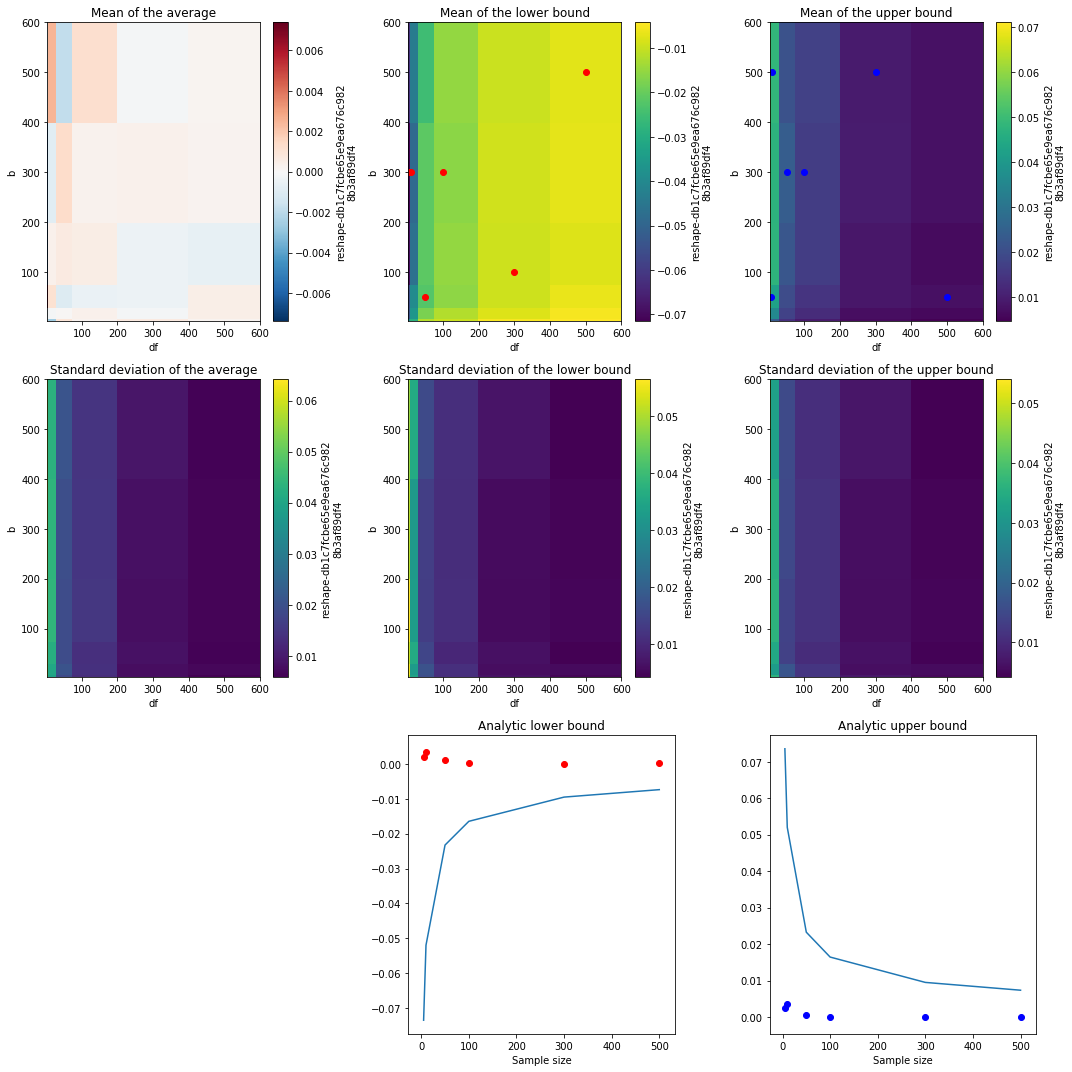

In [72]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,3,1)
out.sel(stats='mean_mean').plot(ax=ax)
ax.set_title('Mean of the average')
ax = fig.add_subplot(3,3,4)
out.sel(stats='mean_rms').plot(ax=ax)
ax.set_title('Standard deviation of the average')
ax = fig.add_subplot(3,3,2)
out.sel(stats='lower_mean').plot(ax=ax)
ax.set_title('Mean of the lower bound')
ax.scatter(df,bootl,c='r',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,5)
out.sel(stats='lower_rms').plot(ax=ax)
ax.set_title('Standard deviation of the lower bound')
ax = fig.add_subplot(3,3,3)
out.sel(stats='higher_mean').plot(ax=ax)
ax.set_title('Mean of the upper bound')
ax.scatter(df,booth,c='b',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,6)
out.sel(stats='higher_rms').plot(ax=ax)
ax.set_title('Standard deviation of the upper bound')
ax = fig.add_subplot(3,3,8)
ax.plot(df,th[0])
ax.set_xlabel('Sample size')
ax.set_title('Analytic lower bound')

ax.scatter(df,vall,c='r',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,9)
ax.plot(df,th[1])
ax.set_xlabel('Sample size')
ax.set_title('Analytic upper bound')
ax.scatter(df,valh,c='b',label='Closer to analytic bound')
plt.tight_layout()

In [5]:
client.close()